## Linking Child Enrolment Pressure with Biometric Update Workload

Objective:  
To examine whether districts with higher child enrolment pressure also experience higher biometric update workloads, indicating combined operational stress on enrolment infrastructure.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [97]:
df1 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv')
df2 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv')
df3 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv')
df4 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv')



In [98]:
df = pd.concat([df1,df2,df3,df4],ignore_index=True)
df.isnull().sum()

date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64

In [ ]:
def clean_state_names(df, state_col="state"):
    df = df.copy()


    df[state_col] = (
        df[state_col]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .str.title()
    )

    state_map = {
        # Odisha
        "Orissa": "Odisha",

        # Puducherry
        "Pondicherry": "Puducherry",

        # Delhi
        "Nct Of Delhi": "Delhi",

        # Telangana
        "Telengana": "Telangana",

        # Uttarakhand
        "Uttaranchal": "Uttarakhand",

        # Chhattisgarh
        "Chhatisgarh": "Chhattisgarh",
        "Chattisgarh": "Chhattisgarh",

        # Tamil Nadu
        "Tamilnadu": "Tamil Nadu",

        # West Bengal
        "Westbengal": "West Bengal",
        "West  Bengal": "West Bengal",
        "West Bangal": "West Bengal",

        # Jammu & Kashmir
        "Jammu & Kashmir": "Jammu And Kashmir",

        # Andaman & Nicobar
        "Andaman & Nicobar Islands": "Andaman And Nicobar Islands",

        # Dadra & Nagar Haveli and Daman & Diu (merged UT)
        "Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
        "Daman & Diu": "Dadra And Nagar Haveli And Daman And Diu",
        "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
        "Dadra & Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    }

    df[state_col] = df[state_col].replace(state_map)

    return df


In [100]:
df = clean_state_names(df, "state")


In [101]:
df['date'].value_counts().sum()
df

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu And Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815
...,...,...,...,...,...,...
1861103,29-12-2025,West Bengal,Uttar Dinajpur,733201,4,9
1861104,29-12-2025,West Bengal,Uttar Dinajpur,733213,0,1
1861105,29-12-2025,West Bengal,West Midnapore,721304,0,3
1861106,29-12-2025,West Bengal,West Midnapore,721451,2,0


In [102]:
df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [103]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True,errors = "coerce")
df['month'] = df['date'].dt.month_name() 


In [104]:
df['month'].value_counts().sum()

np.int64(1861108)

In [105]:
df = df.drop(columns=['date'])

In [106]:
len(df['state'].unique())

36

In [107]:
df = df.rename(columns={
    'bio_age_5_17':'children(5-17)',
    'bio_age_17_' : 'adults'
})

In [108]:
df = df[[
    "month",
    "state",
    "district",
    "pincode",
    "children(5-17)",
    "adults"
]]

In [109]:
df.loc[:,'biometric_total'] = df['children(5-17)'] + df['adults']

In [110]:
bio_district_df =(
    df
    .groupby(['month','state','district'],as_index=False)
    .agg({
        'biometric_total': "sum"
    })
)

### Monthly Trend of Biometric Updates (All Districts)

This chart shows overall monthly biometric update workload across all districts.


In [111]:
month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

bio_district_df["month"] = pd.Categorical(
    bio_district_df["month"],
    categories=month_order,
    ordered=True
)

C:\Users\palas\AppData\Local\Temp\ipykernel_23640\2705943003.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("month",as_index=False)["biometric_total"]


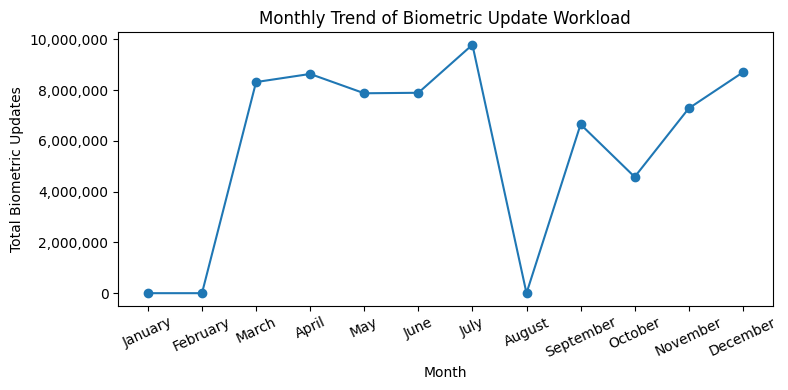

In [112]:
monthly_bio = (
    bio_district_df
    .groupby("month",as_index=False)["biometric_total"]
    .sum()
    .sort_values('month') #type:ignore
)


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(monthly_bio["month"], monthly_bio["biometric_total"], marker="o")
ax.set_xlabel("Month")
ax.set_ylabel("Total Biometric Updates")
ax.set_title("Monthly Trend of Biometric Update Workload")
plt.xticks(rotation=25)

ax.yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.tight_layout()
plt.show()


**Observation:** Biometric update workload varies across months, indicating that operational demand fluctuates over time rather than remaining constant throughout the year.


In [113]:
district_df = pd.read_csv('district_pressure.csv')

In [ ]:
district_df.columns

Index(['month', 'state', 'district', 'children(0-5)', 'children(5-17)',
       'adults', 'child_total', 'total_enrolment', 'child_share',
       'state_avg_child_share', 'pressure_score'],
      dtype='object')

In [115]:
bio_district_df.columns

Index(['month', 'state', 'district', 'biometric_total'], dtype='object')

In [116]:
#Merging_df
combined_df = pd.merge(
    district_df,
    bio_district_df,
    on=['month','state','district'],
    how='inner'
)

In [117]:
combined_df

,month,state,district,children(0-5),children(5-17),adults,child_total,total_enrolment,child_share,state_avg_child_share,pressure_score,biometric_total
0,April,Assam,Baksa,408,483,187,891,1078,0.826531,0.804274,0.022257,3072
1,April,Assam,Barpeta,138,54,23,192,215,0.893023,0.804274,0.088750,11969
2,April,Assam,Biswanath,104,114,32,218,250,0.872000,0.804274,0.067726,1786
3,April,Assam,Bongaigaon,221,87,61,308,369,0.834688,0.804274,0.030415,5647
4,April,Assam,Cachar,988,461,299,1449,1748,0.828947,0.804274,0.024674,12349
...,...,...,...,...,...,...,...,...,...,...,...,...
4616,September,West Bengal,South Twenty Four Parganas,797,316,3,1113,1116,0.997312,0.986031,0.011281,3283
4617,September,West Bengal,Uttar Dinajpur,5458,2585,40,8043,8083,0.995051,0.986031,0.009020,11613
4618,September,West Bengal,West Midnapore,626,221,1,847,848,0.998821,0.986031,0.012789,2465
4619,September,West Bengal,hooghly,0,1,0,1,1,1.000000,0.986031,0.013969,8


In [118]:
analysis_df = combined_df[["month","state","district","pressure_score","biometric_total"]]
analysis_df

,month,state,district,pressure_score,biometric_total
0,April,Assam,Baksa,0.022257,3072
1,April,Assam,Barpeta,0.088750,11969
2,April,Assam,Biswanath,0.067726,1786
3,April,Assam,Bongaigaon,0.030415,5647
4,April,Assam,Cachar,0.024674,12349
...,...,...,...,...,...
4616,September,West Bengal,South Twenty Four Parganas,0.011281,3283
4617,September,West Bengal,Uttar Dinajpur,0.009020,11613
4618,September,West Bengal,West Midnapore,0.012789,2465
4619,September,West Bengal,hooghly,0.013969,8


### Relationship Between Child Enrolment Pressure and Biometric Update Workload

This scatter plot examines whether districts with higher child enrolment pressure also experience higher biometric update workload, indicating combined operational stress.


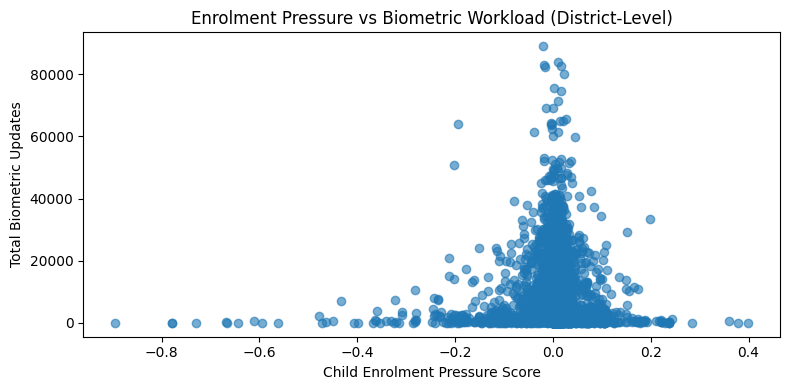

In [119]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(
    analysis_df["pressure_score"],
    analysis_df["biometric_total"],
    alpha=0.6
)

ax.set_xlabel("Child Enrolment Pressure Score")
ax.set_ylabel("Total Biometric Updates")
ax.set_title("Enrolment Pressure vs Biometric Workload (District-Level)")

plt.tight_layout()
plt.show()

In [120]:
#Threshold Selection
pressure_thresshold = analysis_df['pressure_score'].quantile(0.75)
biometric_thresshold = analysis_df['biometric_total'].quantile(0.75)

pressure_thresshold,biometric_thresshold

(np.float64(0.0138811924558456), np.float64(12931.0))

In [121]:
## function to categories district 

def classify(row):
    if row['pressure_score'] >=pressure_thresshold and row['biometric_total'] >=biometric_thresshold:
        return "High Workload"
    elif row['pressure_score'] >=pressure_thresshold and row['biometric_total'] <=biometric_thresshold:
        return "Enrolment-Focused"
    elif row['pressure_score'] <= pressure_thresshold and row['biometric_total'] >=biometric_thresshold:
        return "Update-Focused"
    else:
        return "Stable"
    

In [122]:
##adding category Column in analysis_df
analysis_df.loc[:,'district_type'] = analysis_df.apply(classify,axis=1)

C:\Users\palas\AppData\Local\Temp\ipykernel_23640\1461644960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[:,'district_type'] = analysis_df.apply(classify,axis=1)


### District Classification Based on Enrolment Pressure and Biometric Workload

Districts are grouped into four operational categories based on whether they exhibit high or low enrolment pressure and biometric update workload.


In [123]:
category_counts = analysis_df['district_type'].value_counts().reset_index()
category_counts.columns = ['district_type','count'] 
category_counts

,district_type,count
0,Stable,2566
1,Update-Focused,899
2,Enrolment-Focused,898
3,High Workload,258


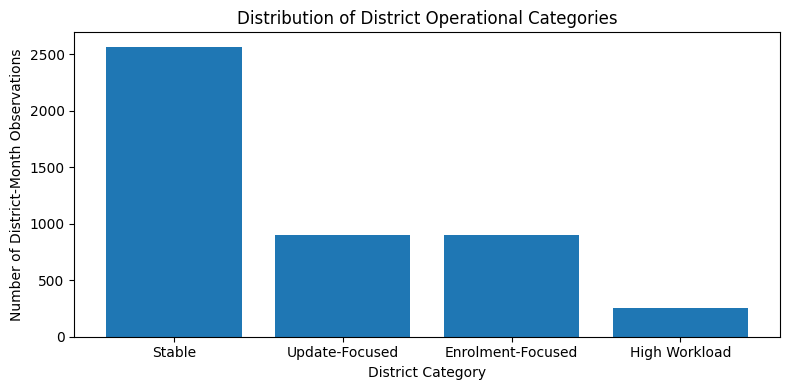

In [124]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(category_counts['district_type'],category_counts['count'])
ax.set_xlabel('District Category')
ax.set_ylabel("Number of District-Month Observations")
ax.set_title("Distribution of District Operational Categories")

plt.tight_layout()
plt.show()

**Observation:** While the majority of districts operate under stable conditions, a non-trivial proportion experience either enrolment-focused or update-focused stress, and a smaller critical subset faces combined high enrolment pressure and high biometric update workload, indicating concentrated operational stress points.


In [125]:
analysis_df["district_type"].value_counts(normalize=True) * 100

district_type
Stable               55.529106
Update-Focused       19.454663
Enrolment-Focused    19.433023
High Workload         5.583207
Name: proportion, dtype: float64

“Only about ~6% of district-months fall into the Heavy Workload category.”

In [126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
analysis_df.loc[:,['p_norm','b_norm']] = scaler.fit_transform(
    analysis_df[['pressure_score','biometric_total']]
)
analysis_df

,month,state,district,pressure_score,biometric_total,district_type,p_norm,b_norm
0,April,Assam,Baksa,0.022257,3072,Enrolment-Focused,0.708616,0.034499
1,April,Assam,Barpeta,0.088750,11969,Enrolment-Focused,0.759957,0.134446
2,April,Assam,Biswanath,0.067726,1786,Enrolment-Focused,0.743724,0.020052
3,April,Assam,Bongaigaon,0.030415,5647,Enrolment-Focused,0.714915,0.063426
4,April,Assam,Cachar,0.024674,12349,Enrolment-Focused,0.710483,0.138715
...,...,...,...,...,...,...,...,...
4616,September,West Bengal,South Twenty Four Parganas,0.011281,3283,Stable,0.700141,0.036869
4617,September,West Bengal,Uttar Dinajpur,0.009020,11613,Stable,0.698396,0.130447
4618,September,West Bengal,West Midnapore,0.012789,2465,Stable,0.701307,0.027680
4619,September,West Bengal,hooghly,0.013969,8,Enrolment-Focused,0.702217,0.000079


In [127]:
analysis_df.loc[:,'combined_stress'] = analysis_df['p_norm'] + analysis_df['b_norm']

C:\Users\palas\AppData\Local\Temp\ipykernel_23640\1661600572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[:,'combined_stress'] = analysis_df['p_norm'] + analysis_df['b_norm']


In [128]:
top_heavy = (
    analysis_df[analysis_df['district_type']=='High Workload']
    .sort_values('combined_stress',ascending=False)
    .head(10)
)
top_heavy

,month,state,district,pressure_score,biometric_total,district_type,p_norm,b_norm,combined_stress
2394,November,Maharashtra,Nashik,0.017290,82610,High Workload,0.704782,0.928014,1.632796
2407,November,Maharashtra,Thane,0.022427,80050,High Workload,0.708748,0.899255,1.608003
1334,July,Maharashtra,Thane,0.016096,74661,High Workload,0.703860,0.838716,1.542576
1235,July,Gujarat,Ahmedabad,0.027703,65705,High Workload,0.712822,0.738106,1.450928
1770,May,Gujarat,Ahmedabad,0.021348,64796,High Workload,0.707915,0.727895,1.435810
54,April,Delhi,North West Delhi,0.015211,65071,High Workload,0.703176,0.730984,1.434160
1831,May,Maharashtra,Thane,0.045578,59673,High Workload,0.726623,0.670344,1.396967
149,April,Maharashtra,Thane,0.037197,52237,High Workload,0.720152,0.586809,1.306961
56,April,Delhi,South Delhi,0.017482,52703,High Workload,0.704930,0.592044,1.296974
2386,November,Maharashtra,Mumbai,0.032520,51310,High Workload,0.716541,0.576396,1.292936


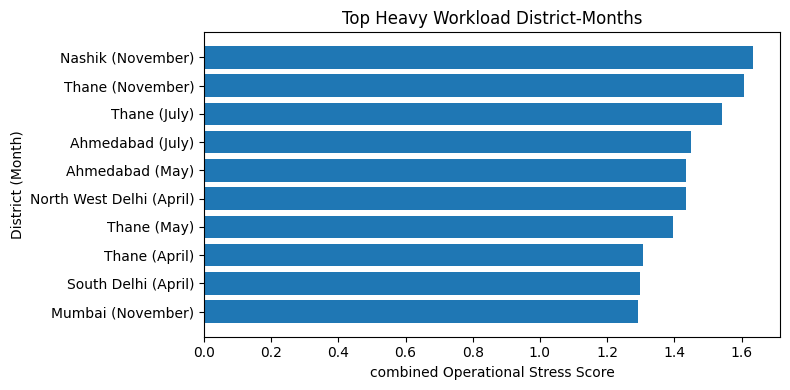

In [129]:
fig, ax = plt.subplots(figsize=(8,4))

ax.barh(
    top_heavy["district"] + " (" + top_heavy["month"] + ")",
    top_heavy['combined_stress']
)

ax.set_xlabel("combined Operational Stress Score")
ax.set_ylabel("District (Month)")
ax.set_title("Top Heavy Workload District-Months")

ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [130]:
heavy_df = analysis_df[analysis_df["district_type"] == "High Workload"]

In [131]:
state_month_heavy = (
    heavy_df
    .groupby("state")
    .size()
    .reset_index(name="heavy_district_count")
    .sort_values('heavy_district_count',ascending=False)
)

In [132]:
state_month_heavy

,state,heavy_district_count
11,Maharashtra,60
17,Uttar Pradesh,30
0,Andhra Pradesh,26
5,Gujarat,25
10,Madhya Pradesh,20
13,Rajasthan,14
2,Bihar,13
19,West Bengal,12
12,Punjab,12
4,Delhi,12


In [133]:
top_state_month = (
    state_month_heavy
    .sort_values("heavy_district_count", ascending=False)
    .head(10)
)

top_state_month

,state,heavy_district_count
11,Maharashtra,60
17,Uttar Pradesh,30
0,Andhra Pradesh,26
5,Gujarat,25
10,Madhya Pradesh,20
13,Rajasthan,14
2,Bihar,13
19,West Bengal,12
12,Punjab,12
4,Delhi,12


### State-Months with Highest Concentration of Heavy Workload Districts

This chart shows state-month combinations where the number of districts facing combined operational stress is highest, indicating periods requiring elevated state-level support.


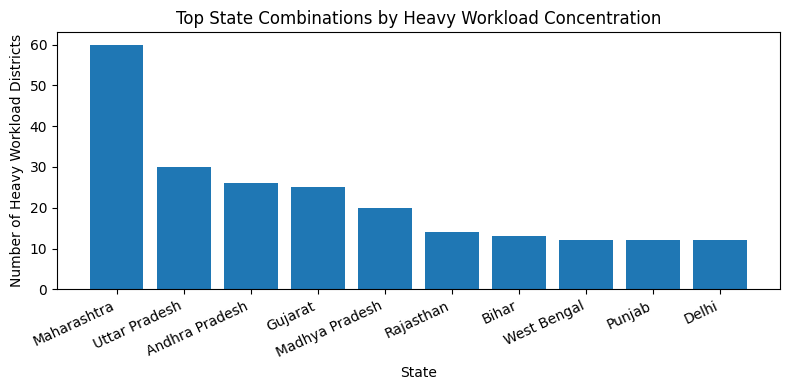

In [134]:
fig, ax = plt.subplots(figsize=(8,4))

labels = top_state_month["state"]

ax.bar(labels, top_state_month["heavy_district_count"])

ax.set_xlabel("State")
ax.set_ylabel("Number of Heavy Workload Districts")
ax.set_title("Top State Combinations by Heavy Workload Concentration")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
state_bio_split = (
    combined_df
    .groupby("state")[["children(5-17)", "adults"]]
    .sum()
    .reset_index()
)
state_bio_split["total"] = state_bio_split["children(5-17)"] + state_bio_split["adults"]
state_bio_split = state_bio_split.sort_values("total", ascending=False)

state_bio = state_bio_split.head(20)
state_bio

,state,children(5-17),adults,total
31,Uttar Pradesh,474749,17638,492387
3,Bihar,314030,10546,324576
17,Madhya Pradesh,115058,9505,124563
26,Rajasthan,112942,5542,118484
18,Maharashtra,81958,8181,90139
33,West Bengal,81330,7405,88735
2,Assam,65893,22748,88641
20,Meghalaya,53171,35226,88397
8,Gujarat,66928,15508,82436
12,Jharkhand,56993,1396,58389


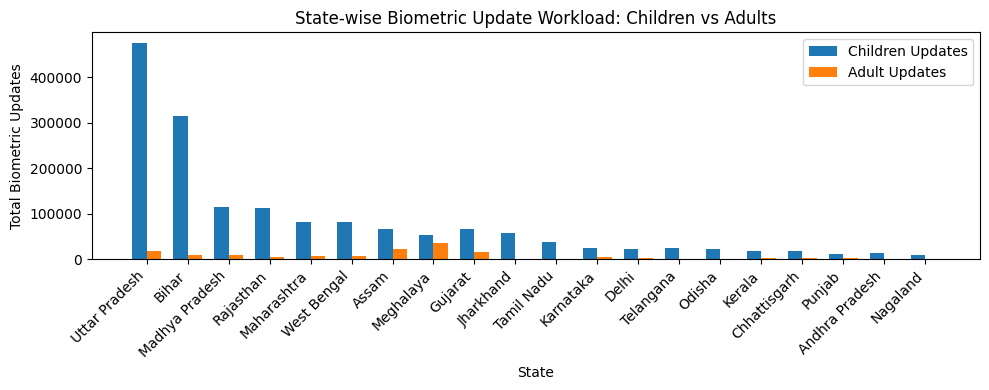

In [162]:
import numpy as np
import matplotlib.pyplot as plt

states = state_bio["state"]
x = np.arange(len(states))
width = 0.35

fig, ax = plt.subplots(figsize=(10,4))

ax.bar(x - width/2, state_bio["children(5-17)"], width, label="Children Updates")
ax.bar(x + width/2, state_bio["adults"], width, label="Adult Updates")

ax.set_xlabel("State")
ax.set_ylabel("Total Biometric Updates")
ax.set_title("State-wise Biometric Update Workload: Children vs Adults")

ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha="right")

ax.legend()
plt.tight_layout()
plt.show()
